In [5]:
import numpy as np
import pandas as pd
import json
import requests
from bs4 import BeautifulSoup
import pandas as pd

# 1. Twitch API data

The URL `https://wind-bow.glitch.me/twitch-api/channels/{CHANNEL_NAME}` is an API from twitch to get data from twitch channels.

Get the data from the following channels:

```
["ESL_SC2", "OgamingSC2", "cretetion", "freecodecamp", 
    "storbeck", "habathcx", "RobotCaleb", "noobs2ninjas",
    "ninja", "shroud", "Dakotaz", "esltv_cs", "pokimane", 
    "tsm_bjergsen", "boxbox", "wtcn", "a_seagull",
    "kinggothalion", "amazhs", "jahrein", "thenadeshot", 
    "sivhd", "kingrichard"]
```

To make into a dataframe that looks like this:

![](twitch.png)

In [6]:
import requests 

channels = ["ESL_SC2", "OgamingSC2", "cretetion", "freecodecamp", 
    "storbeck", "habathcx", "RobotCaleb", "noobs2ninjas",  "ninja", 
    "shroud", "Dakotaz", "esltv_cs", "pokimane", 
    "tsm_bjergsen", "boxbox", "wtcn", "a_seagull",
    "kinggothalion", "amazhs", "jahrein", "thenadeshot", 
    "sivhd", "kingrichard"]

# keys = ['_id','display_name','status','followers','views']

channels_list = []

for display_name in channels:
    r = json.loads(requests.get('https://wind-bow.glitch.me/twitch-api/channels/' + display_name).content)
    if 'error' not in r:
        channels_list.append([r['_id'], r['name'], r['status'], r['followers'], r['views']])
    # print(display_name, r)
# print(channels_list)

In [7]:
df = pd.DataFrame.from_dict(channels_list)
df.columns = ['id', 'display_name', 'status', 'followers', 'views']
df

,id,display_name,status,followers,views
0,30220059,esl_sc2,RERUN: StarCraft 2 - Terminator vs. Parting (P...,135394,60991791
1,71852806,ogamingsc2,UnderDogs - Rediffusion - Qualifier.,40895,20694507
2,90401618,cretetion,It's a Divison kind of Day,908,11631
3,79776140,freecodecamp,Greg working on Electron-Vue boilerplate w/ Ak...,10122,163747
4,86238744,storbeck,None,10,1019
5,6726509,habathcx,Massively Effective,14,764
6,54925078,robotcaleb,Code wrangling,20,4602
7,82534701,noobs2ninjas,Building a new hackintosh for #programming and...,835,48102


In [11]:
# how to see json content in a more presentable way
JSONContent = requests.get('https://wind-bow.glitch.me/twitch-api/channels/ESL_SC2').json()
content = json.dumps(JSONContent, indent = 4, sort_keys=True)
# print(content)

# 2. App Store Reviews

The Apple app store has a `GET` API to get reviews on apps. The URL is:

```
https://itunes.apple.com/{COUNTRY_CODE}/rss/customerreviews/id={APP_ID_HERE}/page={PAGE_NUMBER}/sortby=mostrecent/json
```

Note that you need to provide:

- The country code (eg. `'us'`, `'gb'`, `'ca'`, `'au'`) 

- The app ID. This can be found in the web page for the app right after `id`. For instance, Candy Crush's US webpage is:

`https://apps.apple.com/us/app/candy-crush-saga/id553834731`

So here the ID would be `553834731`.

- The "Page Number". The request responds with multiple pages of data, but sends them one at a time. So you can cycle through the data pages for any app on any country.

### 2.1 English app reviews

Get all english reviews you can for Candy Crush, Tinder, the Facebook app and Twitter (you have to get them from all the english-speaking countries you can think of!).

### 2.2 Best version

For each app, get the version that is the best rated.

Make a visualization of the ratings per versions per app to show this.

### 2.3 Top words

Which word for each app is most common in the 5 star and in the 1-star review's titles?

Note: `df.title.str.get_dummies()` is your friend

Note: This might create a lot of data! Try to break down your analysis in chunks if it doesn't work.

In [ ]:
# 2.1 Get all english reviews you can for Candy Crush, Tinder, the Facebook app and Twitter (you have to get them from all the english-speaking countries you can think of!).

In [5]:
df = pd.DataFrame(columns = ['countries', 'app', 'review'])
empty_df = df.copy()

In [6]:
# GOT IT 🥲 

COUNTRY_CODE = ['us','gb','ca','au']
APP_ID = {'Candy Crush': '553834731','Tinder': '547702041','Facebook': '284882215','Twitter': '333903271'}
PAGE_NUMBER = [str(i) for i in range(1,99)] #not sure how many pages there are, so giving it a long list. 
REVIEW_LIST = []
#df = pd.DataFrame(columns = keys)
# try:
for app, id_n in APP_ID.items():
    for country in COUNTRY_CODE:
        for page in PAGE_NUMBER:
            r = requests.get(f'https://itunes.apple.com/{country}/rss/customerreviews/id={id_n}/page={page}/sortby=mostrecent/json')
            if r:
                cont = json.loads(r.content)
                c = cont['feed']['entry']
                temp_df = empty_df.copy()
                for i in range(0,len(c)):
                    temp_df = pd.concat(
                        [temp_df, pd.DataFrame(
                            data={'countries' : [country], 
                                  'app' : [app], 'review' : [c[i]['content']['label']]})])
                df = df.append(temp_df, ignore_index=True)
            else:
                break;
# except KeyError:
#     pass


In [263]:
# OG DONT TOUCH
COUNTRY_CODE = ['us','gb','ca','au']
APP_ID = {'Candy Crush': '553834731','Tinder': '547702041','Facebook': '284882215','Twitter': '333903271'}
PAGE_NUMBER = [str(i) for i in range(1,10)]
REVIEW_LIST = []
#df = pd.DataFrame(columns = keys)
try:
    for app, id_n in APP_ID.items():
        print(app)
        for country in COUNTRY_CODE:
            print(country)
            for page in PAGE_NUMBER:
                print(page)
                r = requests.get(f'https://itunes.apple.com/{country}/rss/customerreviews/id={id_n}/page={page}/sortby=mostrecent/json')
                cont = json.loads(r.content)
                c = cont['feed']['entry']
                temp_df = empty_df.copy()
                for i in range(0,len(c)):
                    # print(c[i]['content']['label'])
                    temp_df = pd.concat([temp_df, pd.DataFrame(data={'countries' : [country], 'app' : [app], 'review' : [c[i]['content']['label']]})])
                    # temp_df.iloc[i,0] = country
                    # temp_df.iloc[i,1] = app
                    # temp_df.iloc[i,2] = c[i]['content']['label']
                df = df.append(temp_df, ignore_index=True)
                    # print("\n{0}{1}{2}".format(country, app, c[i]['content']['label']))
except KeyError:
    pass


Candy Crush
us
1
2
3
4
5
6
7
8
9
gb
1
2
3
4
5
6
7
8
9
ca
1
2
3
4
5
6
7
8
9
au
1
2
3
4
5
6
7
8
9
Tinder
us
1
2
3
4
5
6
7
8
9
gb
1
2
3
4
5
6
7
8
9
ca
1
2
3
4
5
6
7
8
9
au
1
2
3
4
5
6
7
8
9
Facebook
us
1
2
3
4
5
6
7
8
9
gb
1
2
3
4
5
6
7
8
9
ca
1
2
3
4
5
6
7
8
9
au
1
2
3
4
5
6
7
8
9
Twitter
us
1
2
3
4
5
6
7
8
9
gb
1
2
3
4
5
6
7
8
9
ca
1
2
3
4
5
6
7
8
9
au
1
2
3
4
5
6
7
8
9


In [226]:
df.shape, temp_df.shape

((3276750, 3), (3276769, 3))

In [228]:
df.iloc[0,2]

'This game is great I love it and I love having to do everything something about this game is really addictive and I love it'

In [312]:
df

,countries,app,review
0,us,Candy Crush,Wonderfully relaxing and easy
1,us,Candy Crush,This game is great I love it and I love having...
2,us,Candy Crush,I wanted to give you feedback as you’ve giving...
3,us,Candy Crush,I’ve been playing this game for about week and...
4,us,Candy Crush,I understand that games need to make money to ...
...,...,...,...
7995,au,Twitter,Just your typical media censorship outlet. The...
7996,au,Twitter,Too much censorship and war against free speec...
7997,au,Twitter,Just on it to see how childish the two act aga...
7998,au,Twitter,"I hate Trump, he has right to express his opin..."


In [14]:
df_rating = pd.DataFrame(columns = ['countries', 'app', 'version', 'rating'])
empty_df_rating = df_rating.copy()

In [15]:
# trying to get im:version and label and im:rating and label 

COUNTRY_CODE = ['us','gb','ca','au']
APP_ID = {'Candy Crush': '553834731','Tinder': '547702041','Facebook': '284882215','Twitter': '333903271'}
PAGE_NUMBER = [str(i) for i in range(1,99)]
REVIEW_LIST = []
#df = pd.DataFrame(columns = keys)
# try:
for app, id_n in APP_ID.items():
    print(app)
    for country in COUNTRY_CODE:
        print(country)
        for page in PAGE_NUMBER:
            print(page)
            r = requests.get(f'https://itunes.apple.com/{country}/rss/customerreviews/id={id_n}/page={page}/sortby=mostrecent/json')
            print(r)
            if r:
                cont = json.loads(r.content)
                c = cont['feed']['entry']
                temp_df_rating = empty_df_rating.copy()
                for i in range(0,len(c)):
                    temp_df_rating = pd.concat(
                        [temp_df_rating, pd.DataFrame(
                            data={'countries' : [country], 
                                  'app' : [app], 'version' : [c[i]['im:version']['label']], 'rating' : [c[i]['im:rating']['label']]})])
                df_rating = df_rating.append(temp_df_rating, ignore_index=True)
            else:
                break;
# except KeyError:
#     pass

Candy Crush
us
1
<Response [200]>
2
<Response [200]>
3
<Response [200]>
4
<Response [200]>
5
<Response [200]>
6
<Response [200]>
7
<Response [200]>
8
<Response [200]>
9
<Response [200]>
10
<Response [200]>
11
<Response [400]>
gb
1
<Response [200]>
2
<Response [200]>
3
<Response [200]>
4
<Response [200]>
5
<Response [200]>
6
<Response [200]>
7
<Response [200]>
8
<Response [200]>
9
<Response [200]>
10
<Response [200]>
11
<Response [400]>
ca
1
<Response [200]>
2
<Response [200]>
3
<Response [200]>
4
<Response [200]>
5
<Response [200]>
6
<Response [200]>
7
<Response [200]>
8
<Response [200]>
9
<Response [200]>
10
<Response [200]>
11
<Response [400]>
au
1
<Response [200]>
2
<Response [200]>
3
<Response [200]>
4
<Response [200]>
5
<Response [200]>
6
<Response [200]>
7
<Response [200]>
8
<Response [200]>
9
<Response [200]>
10
<Response [200]>
11
<Response [400]>
Tinder
us
1
<Response [200]>
2
<Response [200]>
3
<Response [200]>
4
<Response [200]>
5
<Response [200]>
6
<Response [200]>
7
<Respo

In [37]:
df_rating.groupby('version')['rating'].mean()

version
           1.000000
1.148.0    3.500000
1.149.0    3.166667
1.150.1    2.800000
1.151.0    2.500000
             ...   
8.50       2.962963
8.51       2.258741
8.52       2.395833
8.52.1     2.365280
8.53       2.469136
Name: rating, Length: 88, dtype: float64

In [29]:
df_rating.rating = df_rating.rating.astype(int)

In [91]:
df_rating['version'] = pd.to_numeric(df_rating['version'])

[Text(0, 0, '850.0'),
 Text(0, 0, '3040.0'),
 Text(0, 0, '11260.0'),
 Text(0, 0, '11541.0')]

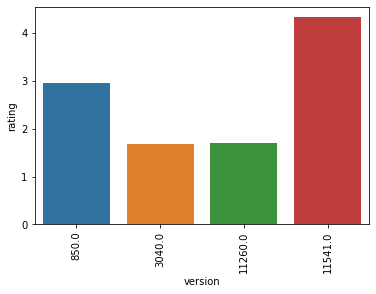

In [197]:
# plt, ax = plt.subplots(figsize = (12,8))

plot=sns.barplot(x = 'version', y='rating', data=top_versions)
# plt.setp(plot.get_xticklabels(), rotation=90)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

# want it with the app name (and the version?)

[Text(0, 0, '842.0'),
 Text(0, 0, '843.0'),
 Text(0, 0, '844.0'),
 Text(0, 0, '845.0'),
 Text(0, 0, '848.0'),
 Text(0, 0, '850.0'),
 Text(0, 0, '851.0'),
 Text(0, 0, '852.0'),
 Text(0, 0, '853.0'),
 Text(0, 0, '1130.0'),
 Text(0, 0, '1210.0'),
 Text(0, 0, '1950.0'),
 Text(0, 0, '3000.0'),
 Text(0, 0, '3010.0'),
 Text(0, 0, '3020.0'),
 Text(0, 0, '3021.0'),
 Text(0, 0, '3030.0'),
 Text(0, 0, '3040.0'),
 Text(0, 0, '3041.0'),
 Text(0, 0, '3050.0'),
 Text(0, 0, '7515.0'),
 Text(0, 0, '8425.0'),
 Text(0, 0, '8441.0'),
 Text(0, 0, '8461.0'),
 Text(0, 0, '8471.0'),
 Text(0, 0, '8521.0'),
 Text(0, 0, '11220.0'),
 Text(0, 0, '11230.0'),
 Text(0, 0, '11240.0'),
 Text(0, 0, '11241.0'),
 Text(0, 0, '11250.0'),
 Text(0, 0, '11260.0'),
 Text(0, 0, '11261.0'),
 Text(0, 0, '11270.0'),
 Text(0, 0, '11280.0'),
 Text(0, 0, '11290.0'),
 Text(0, 0, '11300.0'),
 Text(0, 0, '11310.0'),
 Text(0, 0, '11480.0'),
 Text(0, 0, '11490.0'),
 Text(0, 0, '11501.0'),
 Text(0, 0, '11510.0'),
 Text(0, 0, '11520.0'),
 Te

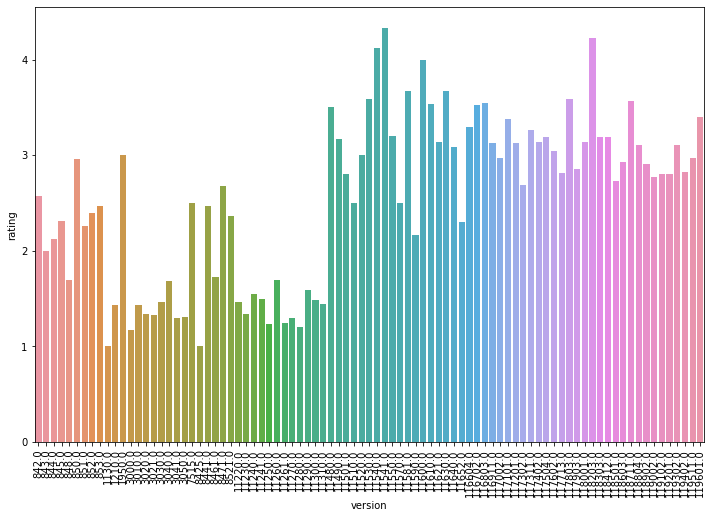

In [156]:
# For each app, get the version that is the best rated.
# Make a visualization of the ratings per versions per app to show this.
import seaborn as sns
import matplotlib.pyplot as plt 


df_rating.groupby(['app', 'version'])['rating'].mean()
x = df_rating.groupby(['app', 'version'])
plt, ax = plt.subplots(figsize = (12,8))

plot=sns.barplot(x = 'version', y='rating', data=df_sorted)
# plt.setp(plot.get_xticklabels(), rotation=90)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
# sns.histplot(data=df_rating, x='version', y='rating')
## WAS HERE 

In [144]:
df_rating.groupby(['app','version'])['rating'].mean()

app          version
Candy Crush  1950.0     3.000000
             11480.0    3.500000
             11490.0    3.166667
             11501.0    2.800000
             11510.0    2.500000
                          ...   
Twitter      8425.0     1.000000
             8441.0     2.469388
             8461.0     1.727273
             8471.0     2.674419
             8521.0     2.365280
Name: rating, Length: 87, dtype: float64

In [166]:
for app, id_n in APP_ID.items():
    idx = df_sort[df_sort.app==app].rating.idxmax()
    vers = 
    print(f'{app}: {df_sort[df_sort.app==app].rating.max()}')


Candy Crush: 4.333333333333333
Tinder: 1.6923076923076923
Facebook: 1.6785714285714286
Twitter: 2.962962962962963


In [195]:
top_versions.index

Index(['Candy Crush', 'Facebook', 'Tinder', 'Twitter'], dtype='object', name='app')

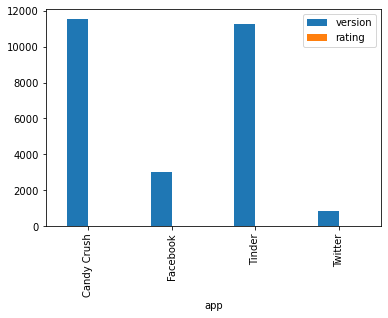

In [189]:
top_versions = df_sorted.groupby('app').first()
top_versions.plot(kind='bar')

In [185]:
df_sort = df_rating.groupby(['app','version'], as_index=False)['rating'].mean()
df_sorted = df_sort.sort_values(by=['app','rating'], ascending=False)
df_sorted.head(50)

,app,version,rating
77,Twitter,850.0,2.962963
85,Twitter,8471.0,2.674419
72,Twitter,842.0,2.571429
81,Twitter,7515.0,2.500000
83,Twitter,8441.0,2.469388
80,Twitter,853.0,2.469136
79,Twitter,852.0,2.395833
86,Twitter,8521.0,2.365280
75,Twitter,845.0,2.314286
78,Twitter,851.0,2.258741


In [142]:
df_rating.groupby(['app','version'])['rating'].mean().sort_values()[:10]
# df_rating.sort_values?

app       version
Tinder    1130.0     1.000000
Twitter   8425.0     1.000000
Facebook  3000.0     1.174927
Tinder    11280.0    1.205128
          11250.0    1.230769
          11261.0    1.240741
Facebook  3041.0     1.292398
Tinder    11270.0    1.300000
Facebook  3050.0     1.306389
          3021.0     1.331169
Name: rating, dtype: float64

In [86]:
len(range(0,8000))

8000

In [89]:

# df_rating['version'] = df_rating['version'].astype(str)
df_rating['version'] = df_rating['version'].str.replace('.', '')
df_rating['version'][650:700]

def make_int(dfs):
    for i in range(0,dfs.shape[0]):
        dfs[i] = pd.to_numeric(dfs[i])
        print(dfs[i])

make_int(df_rating['version'])

1
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11261
11260
11260
11260
11260
11260
11260
11260
11260
11260
11260
11260
11260
11260
11250
11250
11250
11250
11250
11250
11250
11250
11250
11250
11250
11250
11250
11250
11250
11250
11250
11250
11250
11250
11250
11250
11250
11250
11250
11250
11241
11241
11241
11241
11241
11241
11241
11241
11241
11241
11241
11241
11241
11241
11241
11241
11241
11241
11241
11241
11241
11241
11240
11240
11240
11240
11240
11240
11240
11240
11240
11240
11240
11240
11240
11240
11240
11240
11240
11240
11240
11240
11240
11240
11240
11240
11240
11240
11240
11240
11240
11240
11240
11240
11240
11240
11240
11230
11230
11230
11230
11230
11230
11230
11230
11230
11230
11230
11230
11230
11230
11230
11230
11230
11230
11230
11230
11230
11230
11230
11230
11

In [31]:
df_rating.describe()

,rating
count,8000.000000
mean,1.980250
std,1.526729
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,5.000000


In [276]:
# url = f'https://itunes.apple.com/{COUNTRY_CODE}/rss/customerreviews/id={APP_ID_HERE}/page={PAGE_NUMBER}/sortby=mostrecent/json'

CANDYCRUSH = '553834731'
TINDER = '547702041'
FACEBOOK = '284882215'
TWITTER = '333903271'

app_ids = [CANDYCRUSH, TINDER, FACEBOOK, TWITTER]

COUNTRY_CODE = ['us', 'gb', 'ca', 'au', 'nz', 'ie', 'za', 'fr']

# PAGE_NUMBER = str(range(1,11))
PAGE_NUMBER = ['1', '2']

url = f'https://itunes.apple.com/{COUNTRY_CODE}/rss/customerreviews/id={app_ids}/page={PAGE_NUMBER}/sortby=mostrecent/json'

reviews_list = []

for app in app_ids:
    # print(app)
    for country in COUNTRY_CODE:
        # print(country)
        for page in PAGE_NUMBER:
            # print(page)
            r = json.loads(requests.get('https://itunes.apple.com/' + country + '/rss/customerreviews/id=' + app +'/page=' + page +'/sortby=mostrecent/json').content)
            # m = requests.get('https://itunes.apple.com/' + country + '/rss/customerreviews/id=' + app +'/page=' + page +'/sortby=mostrecent/json')
            # soup = BeautifulSoup(m.content, 'html.parser')
            if 'error' not in r:
                reviews_list.append(r['feed']['entry'][1]['im:version'])
                # df = pd.DataFrame(reviews_list)
                # df.shape[1]
                # print(df.applymap(lambda x: x['content']['label']))
                # df = df.applymap(lambda x: x['content']['label'])
                # reviews_list.append((r['feed']['entry'][0]['content']['label']))
                # print(r)
# reviews_list

pd.DataFrame(reviews_list)
# df.head()
# we want to use 'im:version' then "label", and 'im:rating' then 'label'

,label
0,1.195.1.1
1,1.195.1.1
2,1.195.1.1
3,1.194.0.2
4,1.195.1.1
...,...
59,8.40.1
60,8.52.1
61,8.48
62,8.53


In [272]:
pd.DataFrame(reviews_list)[0][0]

{'author': {'uri': {'label': 'https://itunes.apple.com/us/reviews/id327731857'},
  'name': {'label': 'sassyyaya'},
  'label': ''},
 'im:version': {'label': '1.195.1.1'},
 'im:rating': {'label': '5'},
 'id': {'label': '7002943776'},
 'title': {'label': 'Simply Fun'},
 'content': {'label': 'Wonderfully relaxing and easy',
  'attributes': {'type': 'text'}},
 'link': {'attributes': {'rel': 'related',
   'href': 'https://itunes.apple.com/us/review?id=553834731&type=Purple%20Software'}},
 'im:voteSum': {'label': '0'},
 'im:contentType': {'attributes': {'term': 'Application',
   'label': 'Application'}},
 'im:voteCount': {'label': '0'}}

In [169]:
m = requests.get('https://itunes.apple.com/' + country + '/rss/customerreviews/id=' + app +'/page=' + page +'/sortby=mostrecent/json')
soup = BeautifulSoup(m.content, 'html.parser')
soup.prettify()

i":{"label":"https://itunes.apple.com/fr/reviews/id292337730"}, "name":{"label":"OJ35"}, "label":""}, "im:version":{"label":"8.48"}, "im:rating":{"label":"1"}, "id":{"label":"6907794039"}, "title":{"label":"Stories + pub"}, "content":{"label":"Entre la publicité et les stories plus beaucoup de place pour le contenue.", "attributes":{"type":"text"}}, "link":{"attributes":{"rel":"related", "href":"https://itunes.apple.com/fr/review?id=333903271&amp;type=Purple%20Software"}}, "im:voteSum":{"label":"0"}, "im:contentType":{"attributes":{"term":"Application", "label":"Application"}}, "im:voteCount":{"label":"0"}}, \n{"author":{"uri":{"label":"https://itunes.apple.com/fr/reviews/id17992344"}, "name":{"label":"Ok. A la ligne"}, "label":""}, "im:version":{"label":"8.48"}, "im:rating":{"label":"5"}, "id":{"label":"6905043445"}, "title":{"label":"Wallah meilleur réseau"}, "content":{"label":"S/o Alan s/o Marcan", "attributes":{"type":"text"}}, "link":{"attributes":{"rel":"related", "href":"https:

In [170]:
'https://itunes.apple.com/' + country + '/rss/customerreviews/id=' + app +'/page=' + page +'/sortby=mostrecent/json'

'https://itunes.apple.com/fr/rss/customerreviews/id=333903271/page=2/sortby=mostrecent/json'

In [114]:
g = requests.get('https://itunes.apple.com/ca/rss/customerreviews/id=553834731/page=1/sortby=mostrecent/json')
JSONContent = g.json()
content = json.dumps(JSONContent, indent = 4, sort_keys=True)
print(content[:1200])

{
    "feed": {
        "author": {
            "name": {
                "label": "iTunes Store"
            },
            "uri": {
                "label": "http://www.apple.com/ca/itunes/"
            }
        },
        "entry": [
            {
                "author": {
                    "label": "",
                    "name": {
                        "label": "Krystyane73"
                    },
                    "uri": {
                        "label": "https://itunes.apple.com/ca/reviews/id22360065"
                    }
                },
                "content": {
                    "attributes": {
                        "type": "text"
                    },
                    "label": "Paid several times for \u00ab special offers \u00bb of gold bar which i never received. Contacted customer services who blamed apple, apple blamed candu crush. Problem remains: i should have 1000 more gold bar that what i have. Should be considered fraudulus"
                },


In [ ]:
# Extracting full list of player data

players = []

for i in range(len(table)):
    player_ = []

    for td in table[i].find_all("td"):
        player_.append(td.text)

    players.append(player_)

df = pd.DataFrame(players, columns = column_names_clean).set_index("Player")

#Cleaning player name from occassional special character
df.index = df.index.str.replace("*", "")

In [71]:

PAGE_NUMBER = range(1,10)
list(PAGE_NUMBER)

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
# 2.2 For each app, get the version that is the best rated.
# Make a visualization of the ratings per versions per app to show this.

In [ ]:
# 2.3 Which word for each app is most common in the 5 star and in the 1-star review's titles?

In [198]:
df_word = pd.DataFrame(columns = ['countries', 'app', 'title', 'rating'])
empty_df_word = df_word.copy()

In [199]:
df_word

,countries,app,title,rating


In [202]:
# trying to get title and label

COUNTRY_CODE = ['us','gb','ca','au']
APP_ID = {'Candy Crush': '553834731','Tinder': '547702041','Facebook': '284882215','Twitter': '333903271'}
PAGE_NUMBER = [str(i) for i in range(1,99)]
REVIEW_LIST = []
#df = pd.DataFrame(columns = keys)
# try:
for app, id_n in APP_ID.items():
    print(app)
    for country in COUNTRY_CODE:
        print(country)
        for page in PAGE_NUMBER:
            print(page)
            r = requests.get(f'https://itunes.apple.com/{country}/rss/customerreviews/id={id_n}/page={page}/sortby=mostrecent/json')
            print(r)
            if r:
                cont = json.loads(r.content)
                c = cont['feed']['entry']
                temp_df_word = empty_df_word.copy()
                for i in range(0,len(c)):
                    temp_df_word = pd.concat(
                        [temp_df_word, pd.DataFrame(
                            data={'countries' : [country], 
                                  'app' : [app], 'title' : [c[i]['title']['label']], 'rating' : [c[i]['im:rating']['label']]})])
                df_word = df_word.append(temp_df_word, ignore_index=True)
            else:
                break;
# except KeyError:
#     pass

Candy Crush
us
1
<Response [200]>
2
<Response [200]>
3
<Response [200]>
4
<Response [200]>
5
<Response [200]>
6
<Response [200]>
7
<Response [200]>
8
<Response [200]>
9
<Response [200]>
10
<Response [200]>
11
<Response [400]>
gb
1
<Response [200]>
2
<Response [200]>
3
<Response [200]>
4
<Response [200]>
5
<Response [200]>
6
<Response [200]>
7
<Response [200]>
8
<Response [200]>
9
<Response [200]>
10
<Response [200]>
11
<Response [400]>
ca
1
<Response [200]>
2
<Response [200]>
3
<Response [200]>
4
<Response [200]>
5
<Response [200]>
6
<Response [200]>
7
<Response [200]>
8
<Response [200]>
9
<Response [200]>
10
<Response [200]>
11
<Response [400]>
au
1
<Response [200]>
2
<Response [200]>
3
<Response [200]>
4
<Response [200]>
5
<Response [200]>
6
<Response [200]>
7
<Response [200]>
8
<Response [200]>
9
<Response [200]>
10
<Response [200]>
11
<Response [400]>
Tinder
us
1
<Response [200]>
2
<Response [200]>
3
<Response [200]>
4
<Response [200]>
5
<Response [200]>
6
<Response [200]>
7
<Respo

In [203]:
df_word

,countries,app,title,rating
0,us,Candy Crush,Why is Candy Crush pasting from my clipboard?,1
1,us,Candy Crush,No access,1
2,us,Candy Crush,Doesn’t open anymore,4
3,us,Candy Crush,Won’t load,5
4,us,Candy Crush,AY YO MY MOTHER IS A GOD SHE IS NUMBER ONE ON ...,5
...,...,...,...,...
7995,au,Twitter,Political Bias,1
7996,au,Twitter,AWESOME,5
7997,au,Twitter,Recent tweet notification is annoying,4
7998,au,Twitter,Advertisement,1


In [258]:
df_word_5 = df_word[df_word.rating == '5']

In [259]:
df_word_5['title'] = df_word_5['title'].str.extract('([aA-zZ][\w\s]+)')


In [280]:
df_word_5[df_word_5.title.isnull()]

,countries,app,title,rating
109,us,Candy Crush,NaN,5
140,us,Candy Crush,NaN,5
174,us,Candy Crush,NaN,5
217,us,Candy Crush,NaN,5
539,gb,Candy Crush,NaN,5
750,gb,Candy Crush,NaN,5
897,gb,Candy Crush,NaN,5
927,gb,Candy Crush,NaN,5
948,gb,Candy Crush,NaN,5
1100,ca,Candy Crush,NaN,5


In [279]:
df_word_5['title'] = df_word_5['title'].apply(lambda x: 'NaN' if x == 'NaN' else x)

In [287]:
all_words = df_word_5.title.str.split(" ")
all_words = all_words.astype('str')

In [290]:
all_words

3                                                 ['Won']
4       ['AY', 'YO', 'MY', 'MOTHER', 'IS', 'A', 'GOD',...
9                                      ['Candy', 'crush']
21                                      ['Relaxes', 'me']
22                                 ['Get', 'the', 'game']
                              ...                        
7961                                 ['Happy', 'travels']
7976                                            ['Trump']
7987                                               ['RT']
7988                ['Best', 'ever', 'app', 'so', 'fast']
7996                                          ['AWESOME']
Name: title, Length: 1294, dtype: object

In [323]:
words = []
for word in all_words:
    for w in word:
        words.append(w.lower())
        set_words = set(words)
        # set(set_words.lower() for e in set_words)

# len(set_words)
# len(set(set_words))
len(set_words)

# have all the lowercase words, now need to get rid of emojis, and do a 're-set' (later just emojis remove first then set)
# Then can try some kind of IF-IDF once have some OHE of the words and in which row they show up 


44

In [333]:
all_words_reset = all_words.reset_index()

In [334]:
all_words_reset

,index,title
0,3,['Won']
1,4,"['AY', 'YO', 'MY', 'MOTHER', 'IS', 'A', 'GOD',..."
2,9,"['Candy', 'crush']"
3,21,"['Relaxes', 'me']"
4,22,"['Get', 'the', 'game']"
...,...,...
1289,7961,"['Happy', 'travels']"
1290,7976,['Trump']
1291,7987,['RT']
1292,7988,"['Best', 'ever', 'app', 'so', 'fast']"


In [337]:
from collections import Counter
titles = []
for i in range(len(all_words_reset.index)):
    title_phrase = all_words_reset['title'][i].split()
    titles.append(title_phrase)
word_list = [item for sublist in titles for item in sublist ]
counts = Counter(word_list)
counts

        "['Very',": 9,
         "'good',": 7,
         "'so',": 11,
         "'far']": 2,
         "'candy']": 2,
         "['Mind',": 1,
         "'exercise']": 1,
         "['Covid',": 2,
         "'relief']": 1,
         "['Amazing',": 6,
         "'and',": 18,
         "'addicting']": 2,
         "'Relaxing',": 1,
         "['Lol',": 2,
         "'dis',": 1,
         "'old']": 1,
         "['Player']": 1,
         "'play']": 3,
         "'SAGA']": 1,
         "['Pedal',": 1,
         "'partner']": 1,
         "['WTH']": 1,
         "['Love']": 2,
         "'keeps',": 1,
         "'crashing']": 3,
         "'time']": 4,
         "['m',": 3,
         "'an',": 2,
         "'addicted']": 2,
         "'AWSOME']": 1,
         "['Melanie']": 1,
         "'fun',": 3,
         "['Ms']": 2,
         "['Downriver',": 1,
         "'MI',": 1,
         "'JC']": 1,
         "['MY',": 1,
         "'fav',": 1,
         "'review']": 7,
         "['Really',": 5,
         "['Lizzard']": 1,
         "[

In [309]:
flatten = lambda t: [item for sublist in t for item in sublist]
# flatten(all_words)
#lol this grabs every letter

In [300]:
flatten = lambda all_words: [item for sublist in all_words for item in sublist]

In [321]:
all_words

3                                                 ['Won']
4       ['AY', 'YO', 'MY', 'MOTHER', 'IS', 'A', 'GOD',...
9                                      ['Candy', 'crush']
21                                      ['Relaxes', 'me']
22                                 ['Get', 'the', 'game']
                              ...                        
7961                                 ['Happy', 'travels']
7976                                            ['Trump']
7987                                               ['RT']
7988                ['Best', 'ever', 'app', 'so', 'fast']
7996                                          ['AWESOME']
Name: title, Length: 1294, dtype: object

In [322]:
pd.get_dummies(all_words)

,"['A', 'cesspool', 'of', 'opinions']","['A', 'nice', 'place']","['A', 'safe', 'space', 'for', 'transgender', 'people']","['A', 'sensational', 'platform']","['A', 'very', 'good', 'game']","['A', 'voice', 'to', 'civilised', 'honest', 'people']",['AMAZING'],['ANAZING'],['AWESOME'],['AWRSOME'],...,"['this', 'is', 'going', 'way', 'too', 'far']","['tinder', 'is', 'great']","['tweet', 'important', 'things']","['twitter', 'construction']",['twittor'],"['what', 'happened']",['years'],['yes'],"['yrs', 'of', 'tweets']",nan
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7976,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7988,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [294]:
# Create an empty list 
Row_list =[] 
  
# Iterate over each row 
for index, rows in all_words.iteritems(): 
    # Create list for the current row 
    my_list =rows
      
    # append the list to the final list 
    Row_list.append(my_list) 
    Row_list.explode
# Print the list 
print(Row_list) 

AttributeError: 'list' object has no attribute 'explode'

In [284]:
set_words

{' ',
 "'",
 ',',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '[',
 ']',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 'â',
 'è',
 'é'}

In [254]:
list(set_words).str.extract('([aA-zZ][\w\s]+)')
# set_words.str.extract('([aA-zZ][\w\s]+)')

AttributeError: 'list' object has no attribute 'str'

In [252]:
list(set_words)

['heaven.',
 'more',
 'problem!',
 'force',
 '🍬🍭🍫🍪',
 '',
 'you',
 'show',
 'anyone',
 'ranaut',
 'sweet',
 'space',
 'amazing!',
 'h',
 'her',
 'am',
 'changes',
 'recent',
 'welcoming',
 'man',
 'glitz',
 'great.',
 '😡',
 'hang',
 'need',
 'retweet',
 'click',
 'app!',
 'cesspool',
 'glitch',
 'list',
 '\U0001f972',
 'brill',
 'hffurniture',
 'twitter!',
 'swipe',
 'but...',
 'aplication',
 'candy',
 'casino',
 'ابن',
 'top',
 'meet',
 'ma',
 'choose?',
 'khan',
 'mes',
 'mucho',
 'jc',
 'patient!!',
 'tinder!!',
 'awrsome',
 'hole',
 'melanie',
 'you!',
 'request🥳🤩',
 'جوكم',
 'difficulty',
 'able',
 'hill',
 'today',
 '#love',
 'bye',
 'blocking',
 'du',
 'ode',
 'places',
 'grandma',
 'brilliant',
 'freedom',
 'ahsvshd',
 'here',
 'number',
 'funny,',
 'que',
 'learning',
 'place',
 'car',
 'hate',
 'kazza',
 '👍👍',
 'lara',
 'an',
 '♥️',
 'pense',
 'field',
 '为什么？',
 'bien',
 'without',
 'trump...',
 'x2',
 'twtr',
 'app,',
 'honest',
 'eye',
 'girl',
 'twice',
 'stuff',
 'ds',
 '

In [319]:
a = ['Jaha', 'LADY', 'lady', 'mister', 'Mister', 'eggs', 'lady']

set([e.lower() for e in a])

{'eggs', 'jaha', 'lady', 'mister'}

In [318]:
a

pandas.core.series.Series

In [320]:
# a = pd.Series
pd.get_dummies(a)

,Jaha,LADY,Mister,eggs,lady,mister
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,0,0,1,0
3,0,0,0,0,0,1
4,0,0,1,0,0,0
5,0,0,0,1,0,0
6,0,0,0,0,1,0


In [338]:
# OG STEVEN FOR 2.3

filtered_df = df_titles[(df_titles.Rating==1) | (df_titles.Rating==5)]

# so filtered is just the df where the rating is either 1 or 5

# then:

from collections import Counter
most_ = []
for r in RATING:
    for app, app_id in APP_ID.items():
        star_df = filtered_df[filtered_df.Rating==r]
        app_df = star_df[star_df.App==app]
        app_df['Title'] = app_df['Title'].str.lower()
        app_df['Title'] = app_df['Title'].str.extract('([aA-zZ][\w\s]+)')
        app_df = app_df[app_df['Title'].notna()]
        app_df.reset_index(drop=True,inplace=True)
        titles = []
        for i in range(len(app_df.index)):
            title_phrase = app_df['Title'][i].split()
            titles.append(title_phrase)
        word_list = [item for sublist in titles for item in sublist ]
        counts = Counter(word_list)
        most_word = counts.most_common(1)
        most_.append(most_word)
most_

print(f'Most common word for {r} start(s) in {app} is: {most_word[0][0]}')


SyntaxError: EOL while scanning string literal (<ipython-input-338-3fcda2616630>, line 29)

In [347]:
# filtered_df
# df_word[(df_word.rating=='1')]

In [350]:
# working on this one. Want to see where i'm going wrong so i can use OHE once words are all lower case

filtered_df = df_word[(df_word.rating=='1') | (df_word.rating=='5')]

# so filtered is just the df where the rating is either 1 or 5

# then:
RATING = ['1','5']

from collections import Counter
most_ = []
for r in RATING:
    for app, app_id in APP_ID.items():
        star_df = filtered_df[filtered_df.rating==r]
        app_df = star_df[star_df.app==app]
        app_df['title'] = app_df['title'].str.lower()
        app_df['title'] = app_df['title'].str.extract('([aA-zZ][\w\s]+)')
        app_df = app_df[app_df['title'].notna()]
        app_df.reset_index(drop=True,inplace=True)
        titles = []
        for i in range(len(app_df.index)):
            title_phrase = app_df['title'][i].split()
            titles.append(title_phrase)
        word_list = [item for sublist in titles for item in sublist ]
        counts = Counter(word_list)
        most_word = counts.most_common(1)
        most_.append(most_word)
# most_

        print(f'Most common word for {r} start(s) in {app} is: {most_word[0][0]}')

Most common word for 1 start(s) in Candy Crush is: game
Most common word for 1 start(s) in Tinder is: banned
Most common word for 1 start(s) in Facebook is: censorship
Most common word for 1 start(s) in Twitter is: censorship
Most common word for 5 start(s) in Candy Crush is: candy
Most common word for 5 start(s) in Tinder is: app
Most common word for 5 start(s) in Facebook is: facebook
Most common word for 5 start(s) in Twitter is: twitter


# 3 (STRETCH) IMDB scraping

IMDB has structured web pages. We can exploit this to scrape movie data.

Usinf the following URL:

`https://www.imdb.com/search/title/?groups=top_1000&start={PAGE_NUMBER}&ref_=adv_nxt`

With the following headers in your `GET` request: `{"Accept-Language": "en-US,en;q=0.5"}`

You can generate a dataframe like this one by cycling over the page numbers in the URL requested:

![](IMDB.png)

Note that the following  page attribues will be of interest:

- `div` with a class of `lister-item mode-advanced`

- Various `span` objects within that `div` like `lister-item-year` and `runtime` and `metascore`

In [384]:
from bs4 import BeautifulSoup
titles = []
year = []
imdb = []
metascore = []
votes = []
us_grossMillions = []
timeMin = []


PAGE_NUMBER = range(1,1001, 50)
for page in PAGE_NUMBER:
    r_3 = requests.get(f'https://www.imdb.com/search/title/?groups=top_1000&start={page}&ref_=adv_nxt', {"Accept-Language": "en-US,en;q=0.5"})
# {"Accept-Language": "en-US,en;q=0.5"}
# r_3.content
# m = requests.get('https://itunes.apple.com/' + country + '/rss/customerreviews/id=' + app +'/page=' + page +'/sortby=mostrecent/json')
soup = BeautifulSoup(r_3.content, 'html.parser')
soup.prettify()
content = soup.find('div', {'class':"lister-item mode-advanced"})

movie_div = soup.find_all('div', class_='lister-item mode-advanced')

for container in movie_div:
    # Scraping the movie's name
    name = container.h3.a.text
    titles.append(name)

# i'm here 

In [382]:
movie_div = soup.find_all('div', class_='lister-item mode-advanced')

for container in movie_div:
    # Scraping the movie's name
    name = container.h3.a.text
    titles.append(name)

In [385]:
titles

['Zelig',
 'Central do Brasil',
 'Pink',
 'Talvar',
 'White Heat',
 'Queen',
 'Sanjuro',
 'Duck Soup',
 'Haider',
 'La règle du jeu',
 'Sherlock Jr.',
 'Badhaai ho',
 'The Magdalene Sisters',
 'Chhichhore',
 'Kahaani',
 'G.O.R.A.',
 'Dil Chahta Hai',
 'La Grande Illusion',
 'Hera Pheri',
 'Lifeboat',
 'Le dîner de cons',
 'M.S. Dhoni: The Untold Story',
 "Knockin' on Heaven's Door",
 'Taegukgi hwinalrimyeo',
 'The Muppet Christmas Carol',
 'Veer-Zaara',
 'Auf der anderen Seite',
 'Baby',
 'Udaan',
 'A Wednesday',
 'C.R.A.Z.Y.',
 'The Circus',
 'Special Chabbis',
 'Black',
 'Chak De! India',
 'Andaz Apna Apna',
 'Udta Punjab',
 'Dev.D',
 'English Vinglish',
 'Paan Singh Tomar',
 'A Night at the Opera',
 'Airlift',
 'Munna Bhai M.B.B.S.',
 'Sholay',
 'OMG: Oh My God!',
 'Vizontele',
 'Kai po che!',
 'Lage Raho Munna Bhai',
 'Vicky Donor',
 'Nefes: Vatan Sagolsun']

In [376]:
soup = BeautifulSoup(r_3.content, 'html.parser')
table = soup.find_all(class_='lister-item mode-advanced')
table = soup.find_all(class_='lister-item-year')
table = soup.find_all('h3', {'class':"lister-item-header"})
table

[<h3 class="lister-item-header">
 <span class="lister-item-index unbold text-primary">20.</span>
 <a href="/title/tt0120737/">The Lord of the Rings: The Fellowship of the Ring</a>
 <span class="lister-item-year text-muted unbold">(2001)</span>
 </h3>,
 <h3 class="lister-item-header">
 <span class="lister-item-index unbold text-primary">21.</span>
 <a href="/title/tt1375666/">Inception</a>
 <span class="lister-item-year text-muted unbold">(2010)</span>
 </h3>,
 <h3 class="lister-item-header">
 <span class="lister-item-index unbold text-primary">22.</span>
 <a href="/title/tt1130884/">Shutter Island</a>
 <span class="lister-item-year text-muted unbold">(2010)</span>
 </h3>,
 <h3 class="lister-item-header">
 <span class="lister-item-index unbold text-primary">23.</span>
 <a href="/title/tt5013056/">Dunkirk</a>
 <span class="lister-item-year text-muted unbold">(2017)</span>
 </h3>,
 <h3 class="lister-item-header">
 <span class="lister-item-index unbold text-primary">24.</span>
 <a href="/t

In [368]:
article = ''
for i in content.findAll('p'):
    article = article + ' ' +  i.text


In [355]:
PAGE_NUMBER = range(1,21)
for page in PAGE_NUMBER:
    print(page)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
